# Importy i wczytywanie danych + Profile Report

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pandas_profiling import ProfileReport
from sklearn.preprocessing import LabelEncoder
%matplotlib inline


In [2]:
initial_df = pd.read_csv('insurance.csv')


In [3]:
profile = ProfileReport(initial_df)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# EDA

In [4]:
initial_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
initial_df.shape

(1338, 7)

In [6]:
initial_df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [7]:
initial_df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

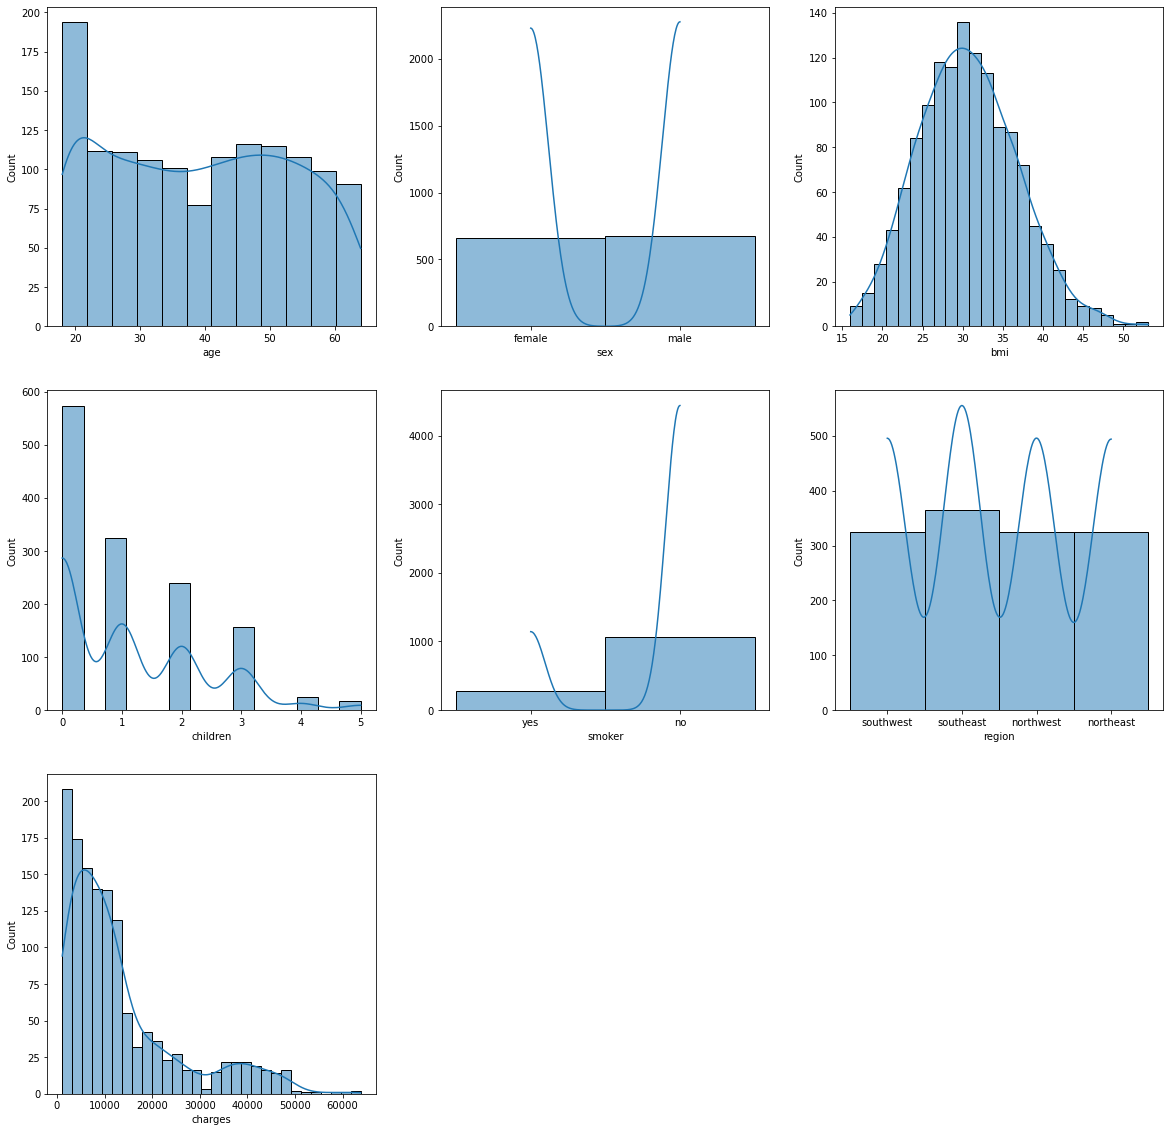

In [8]:
# histogram with kde
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(20, 20))
fig.delaxes(axes[2][1])
fig.delaxes(axes[2][2])

for i, ax in zip(range(7), axes.flat):
    sns.histplot(data=initial_df, x=initial_df.columns[i], kde=True, ax=ax)
plt.show()

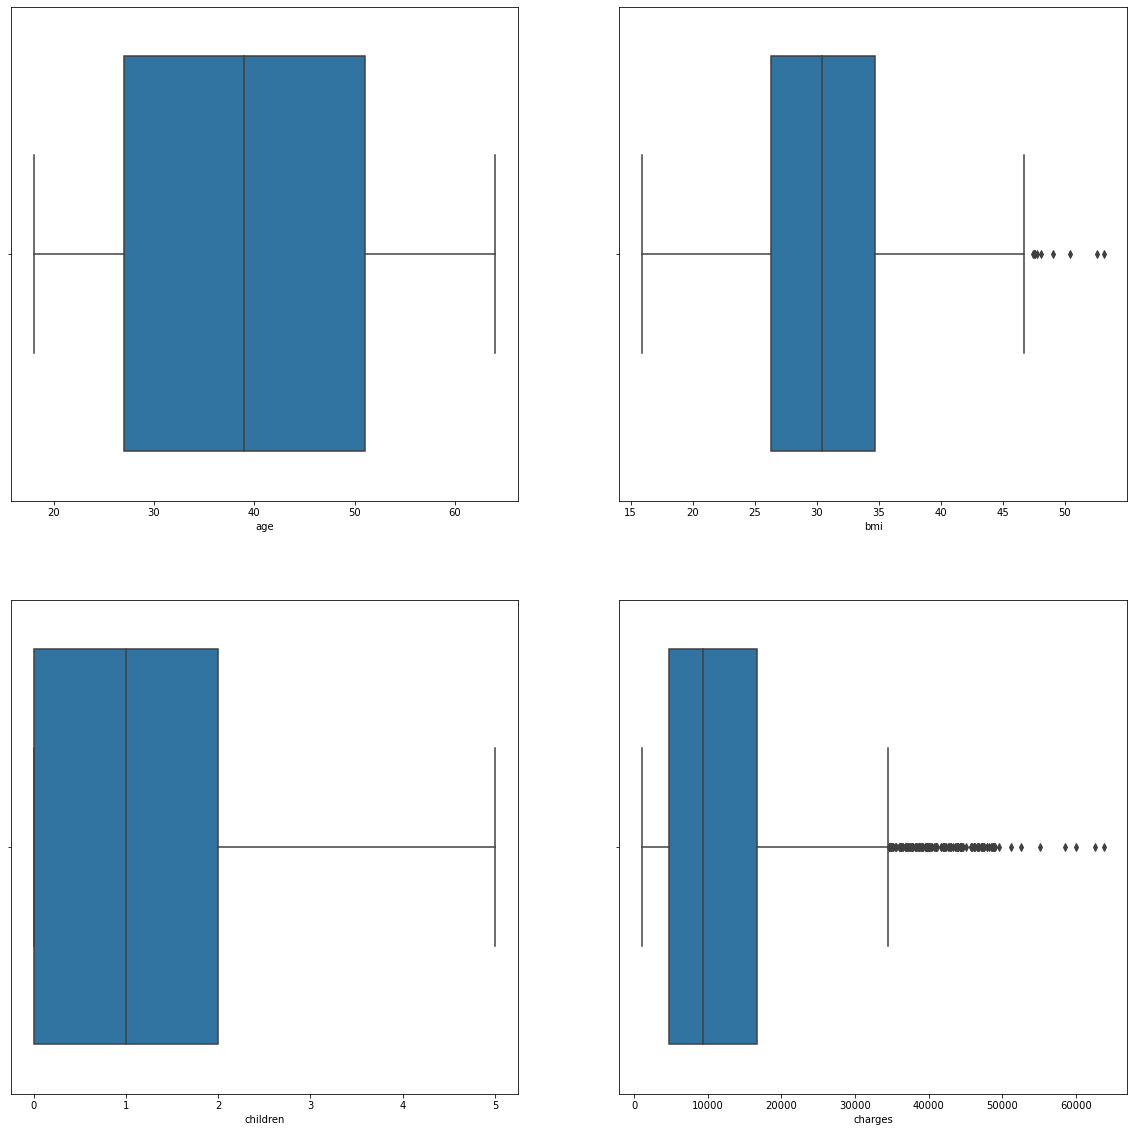

In [9]:
# boxplots
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))
for i, ax in zip(range(4), axes.flat):
    sns.boxplot(x=initial_df[['age', 'bmi', 'children', 'charges']].iloc[:, i], ax=ax)
plt.show()

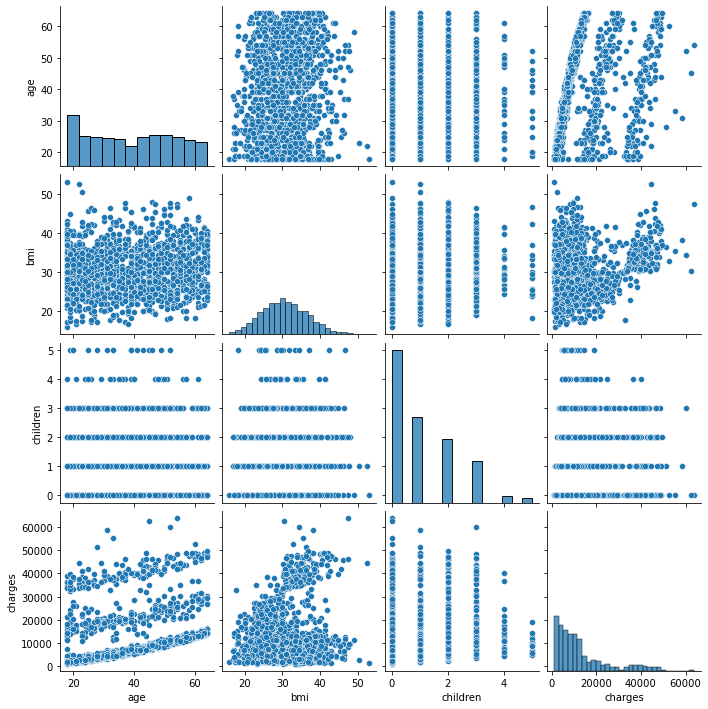

In [10]:
sns.pairplot(initial_df)

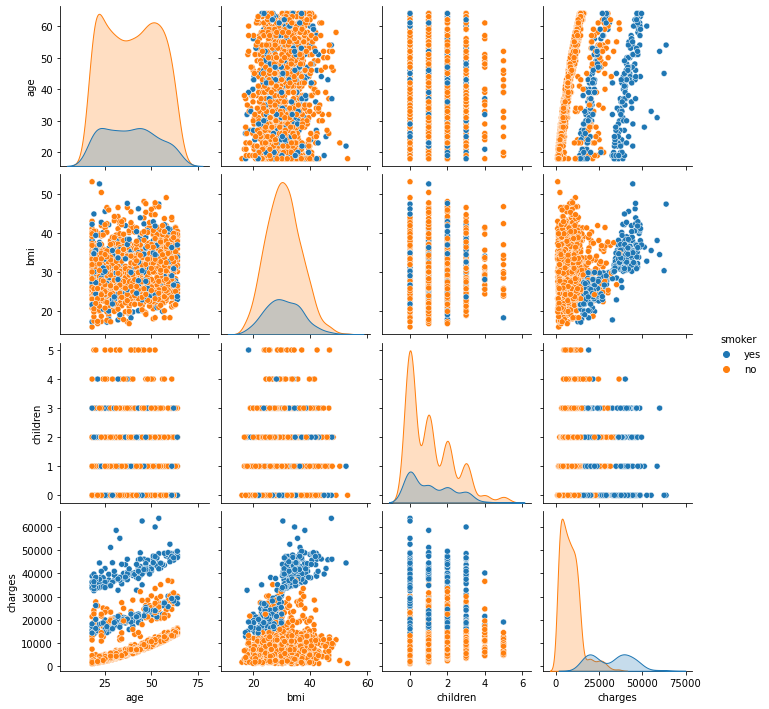

In [11]:
sns.pairplot(initial_df, hue='smoker')

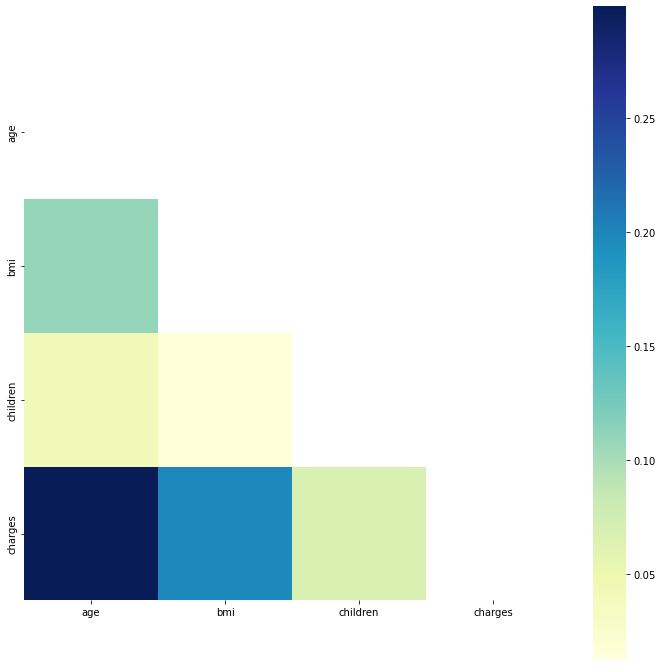

In [12]:
corr = np.corrcoef(np.random.randn(4, 200))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(12, 12))
sns.heatmap(initial_df.corr(), cmap='YlGnBu', mask=mask, square=True)
plt.show()

# Preprocessing

In [13]:
# one hot encoding
df = pd.get_dummies(initial_df, drop_first=True)
# dodanie kategorii otyły (w USA wg jakiegoś medycznego instytu jest po prostu powyżej 30
df["obese"] = df["bmi"].apply(lambda x: 1 if x >= 30 else 0)
# dodanie kategorii otyły i palący
df["obese_smoker"] = df[["obese", "smoker_yes"]].apply(
    lambda x: 1 if (x["obese"] == 1) & (x["smoker_yes"] == 1) else 0, axis=1
)

# EDA cd i szukanie outlierów

<AxesSubplot:>

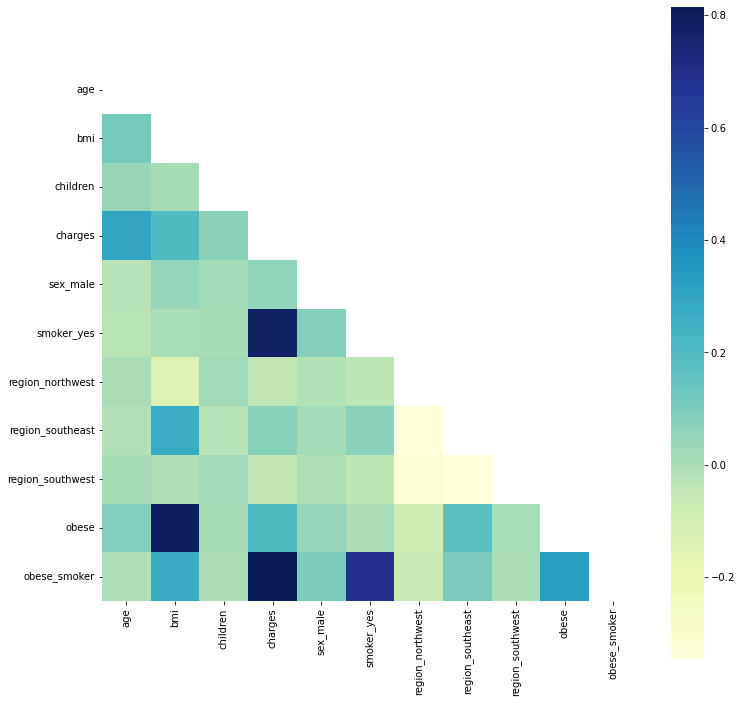

In [14]:
# nowa mapa korelacji
corr = np.corrcoef(np.random.randn(11, 200))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(12, 12))
sns.heatmap(df.corr(), cmap="YlGnBu", mask=mask, square=True)

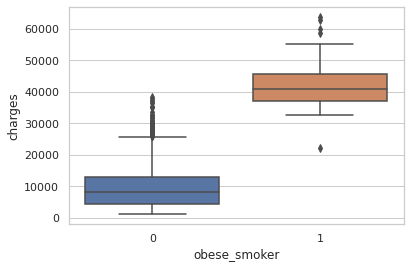

In [15]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(y=df["charges"], x=df["obese_smoker"], whis=1.5)

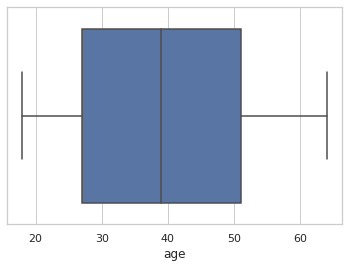

In [16]:
sns.set_theme(style='whitegrid')
ax = sns.boxplot(x=initial_df['age'])

# Podział na zbiór treningowy i testowy

In [17]:
from sklearn.model_selection import train_test_split

X = df.drop('charges', axis=1)
y = df['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Analiza PCA

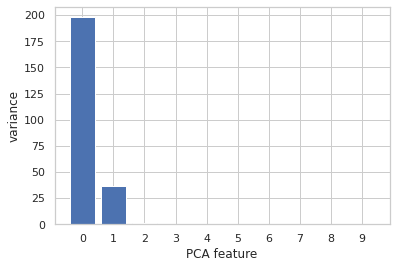

In [18]:
# PCA without standarization - just for comparision
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
pca = PCA(random_state=0)


# Fit the pipeline to 'samples'
pca.fit(X)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

Percentage of variance by component[0.2250378  0.15096013 0.13269335 0.12225973 0.10077208 0.09923312
 0.09291747 0.03209376 0.02576109 0.01827147]


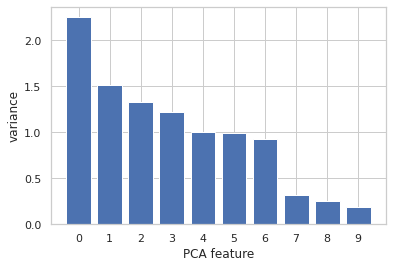

In [19]:
# standarization and PCA
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(ss, pca)
pipeline.fit(X)
print(f'Percentage of variance by component{pca.explained_variance_ratio_}')
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

# Wstępne modelowanie

* Regresja liniowa

In [20]:
from sklearn.linear_model import LinearRegression
lin_reg=LinearRegression()
lin_reg.fit(X_train, y_train)
lin_reg.score(X_test, y_test)

0.8710875054478744

In [21]:
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(ss, lin_reg)
pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

0.8710875054478743

In [22]:
from sklearn.model_selection import cross_val_score

cross_val_score(pipeline, X_train, y_train, cv=5).mean()

0.8517178858864115

* RFC and features importances

0.8646616160986477


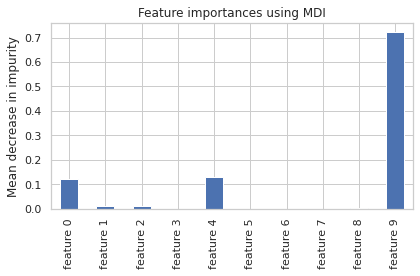

In [24]:
#rfc
from sklearn.ensemble import RandomForestRegressor
rfc = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=1, n_jobs=-1)

rfc.fit(X_train, y_train)
print(rfc.score(X_test, y_test))
feature_names = [f"feature {i}" for i in range(X.shape[1])]
importances = rfc.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)
std = np.std([rfc.feature_importances_ for tree in rfc.estimators_], axis=0)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

* KNeighborsRegressor

In [25]:
# no standarization, no PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

knn_reg = KNeighborsRegressor()
param_grid = {
    'n_neighbors': list(range(4, 41, 4)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
}
search = GridSearchCV(knn_reg, param_grid, cv=10, n_jobs=-1)
search.fit(X_train, y_train)
print('Best parameter (CV score=%0.3f):' % search.best_score_)
print(search.best_params_)
print(search.score(X_test, y_test))

Best parameter (CV score=0.469):
{'n_neighbors': 8, 'p': 1, 'weights': 'distance'}
0.5317472696937628


In [26]:
# after Standarization
pipeline_ss = Pipeline(steps=[('ss', ss), ('knn', knn_reg)])
param_grid_ss = {
    'knn__n_neighbors': list(range(4, 41, 4)),
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2],
}
search_ss = GridSearchCV(pipeline_ss, param_grid_ss, cv=10, n_jobs=-1)
search_ss.fit(X_train, y_train)
print('Best parameter (CV score=%0.3f):' % search_ss.best_score_)
print(search_ss.best_params_)
print(search_ss.score(X_test, y_test))

Best parameter (CV score=0.828):
{'knn__n_neighbors': 12, 'knn__p': 2, 'knn__weights': 'distance'}
0.8353654082702576


In [27]:
# after standarization and PCA
pipeline_pca = Pipeline(steps=[('ss', ss), ('pca', pca), ('knn', knn_reg)])
param_grid_pca = {
    'pca__n_components': list(range(2, 9)),
    'knn__n_neighbors': list(range(4, 41, 4)),
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2],
}
search_pca = GridSearchCV(pipeline_pca, param_grid_pca, cv=5, n_jobs=-1)
search_pca.fit(X_train, y_train)
print('Best parameter (CV score=%0.3f):' % search_pca.best_score_)
print(search_pca.best_params_)
print(search_pca.score(X_test, y_test))

Best parameter (CV score=0.823):
{'knn__n_neighbors': 12, 'knn__p': 1, 'knn__weights': 'distance', 'pca__n_components': 4}
0.8398169526551627


* xgboost bez GridSearch

In [28]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import xgboost as xgb
mm=MinMaxScaler()
ss=StandardScaler()
pca=PCA(n_components=0.95)
xgboost = xgb.XGBRegressor(max_depth = 3, n_estimators=50, learning_rate =.2)
pipeline = make_pipeline(ss, xgboost) #pca?
pipeline.fit(X_train, y_train)
pipeline.score(X_test,y_test)

0.865094164234474

# Alternatywne modele / do dalszych rozważań

* ElasticNet

In [29]:
# after standarization and PCA
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(random_state=0)

pipeline_pca = Pipeline(steps=[('ss', ss), ('pca', pca), ('elastic_net', elastic_net)])
param_grid_pca = {'pca__n_components': list(range(2, 9))}
search_pca = GridSearchCV(pipeline_pca, param_grid_pca, cv=5, n_jobs=-1)
search_pca.fit(X_train, y_train)
print('Best parameter (CV score=%0.3f):' % search_pca.best_score_)
print(search_pca.best_params_)
print(search_pca.score(X_test, y_test))

Best parameter (CV score=0.798):
{'pca__n_components': 8}
0.8205854847750487


* Stacking Regressor

In [30]:
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

final_estimator=LassoCV()

estimators = [
    (
        'RFC',
        RandomForestRegressor(n_estimators=100, max_depth=5, random_state=1, n_jobs=-1),
    ),
    ('GBR', GradientBoostingRegressor()),
    ('Ada', AdaBoostRegressor()),
    ('XGB', xgboost),
]

reg = StackingRegressor(estimators=estimators, cv=10, final_estimator=final_estimator)
pipeline3 = make_pipeline(ss, reg)
reg.fit(X_train, y_train)
print(reg.score(X_test, y_test))

0.8674826240732884


# Inne (obróbka danych, features engineering)

* Przetestowanie podziału na dwa datasety (palący i niepalący)

In [31]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as MSE


X2 = df[df['smoker_yes'] == 0].drop('charges', axis=1)
y2 = df['charges'][df['smoker_yes'] == 0]
# X = df[['age', 'obese_smoker', 'smoker_yes']]
# y = df['charges']
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X2, y2, test_size=0.3, random_state=42
)

X3 = df[df['smoker_yes'] == 1].drop('charges', axis=1)
y3 = df['charges'][df['smoker_yes'] == 0]
# X = df[['age', 'obese_smoker', 'smoker_yes']]
# y = df['charges']
X_train3, X_test3, y_train3, y_test3 = train_test_split(
    X, y, test_size=0.3, random_state=42
)
estimators = [
    RandomForestRegressor(n_estimators=100, max_depth=5, random_state=1, n_jobs=-1),
    GradientBoostingRegressor(),
    AdaBoostRegressor(),
    xgboost,
    SVR(kernel='linear'),
    KNeighborsRegressor(),
]
for estimator in estimators:
    pipeline_estimator = make_pipeline(ss, estimator)
    pipeline_estimator.fit(X_train, y_train)
    y_pred = pipeline_estimator.predict(X_test)
    R2 = pipeline_estimator.score(X_test, y_test)
    mse = MSE(y_test, y_pred)
    rmse = mse ** 0.5
    print(
        f' Full df for estimator {estimator.__class__.__name__} Value of R2 = {R2}, MSE={mse}, RMSE={rmse}'
    )
    pipeline_estimator = make_pipeline(ss, estimator)
    pipeline_estimator.fit(X_train2, y_train2)
    y_pred2 = pipeline_estimator.predict(X_test2)
    R2 = pipeline_estimator.score(X_test2, y_test2)
    mse = MSE(y_test2, y_pred2)
    rmse = mse ** 0.5
    print(
        f' Non smokers for estimator {estimator.__class__.__name__} Value of R2 = {R2}, MSE={mse}, RMSE={rmse}'
    )
    pipeline_estimator = make_pipeline(ss, estimator)
    pipeline_estimator.fit(X_train3, y_train3)
    y_pred3 = pipeline_estimator.predict(X_test3)
    R2 = pipeline_estimator.score(X_test3, y_test3)
    mse = MSE(y_test3, y_pred3)
    rmse = mse ** 0.5
    print(
        f' Smokers for estimator {estimator.__class__.__name__} Value of R2 = {R2}, MSE={mse}, RMSE={rmse}'
    )

 Full df for estimator RandomForestRegressor Value of R2 = 0.865086722995263, MSE=19781565.866548095, RMSE=4447.647228203705
 Non smokers for estimator RandomForestRegressor Value of R2 = 0.42174716775869214, MSE=20020560.162935235, RMSE=4474.434060631046
 Smokers for estimator RandomForestRegressor Value of R2 = 0.8650867229952629, MSE=19781565.86654809, RMSE=4447.647228203704
 Full df for estimator GradientBoostingRegressor Value of R2 = 0.8618961327593699, MSE=20249383.951659665, RMSE=4499.931549663802
 Non smokers for estimator GradientBoostingRegressor Value of R2 = 0.39824914878171347, MSE=20834120.38505288, RMSE=4564.440862258254
 Smokers for estimator GradientBoostingRegressor Value of R2 = 0.8619482912203917, MSE=20241736.253411505, RMSE=4499.081712239899
 Full df for estimator AdaBoostRegressor Value of R2 = 0.756508625680611, MSE=35701754.23777001, RMSE=5975.09449613728
 Non smokers for estimator AdaBoostRegressor Value of R2 = 0.3218038408529543, MSE=23480848.254295994, RMS

* Alternatywny preprocessing i features enginnering (Polynomial)

In [32]:

# dodanie kategorii otyły (w USA wg jakiegoś medycznego instytu jest po prostu powyżej 30
initial_df['bmi_cat'] = pd.cut(x = initial_df['bmi'], bins = [0, 18.5, 24.9, 29.9, 100], labels = ['underweight',
                                                                                  'healthy weight',
                                                                                   'overweight',
                                                                                   'obesity'])

initial_df['age_cat'] = pd.cut(x = initial_df['age'], bins = [0, 35, 56, 100], labels = ['young adult',
                                                                                  'senior adult',
                                                                                   'elder'])




In [33]:
df2 = pd.get_dummies(initial_df)
df2.shape

(1338, 19)

In [34]:
df2["obese_smoker"] = df2[["bmi_cat_obesity", "smoker_yes"]].apply(
    lambda x: 1 if (x["bmi_cat_obesity"] == 1) & (x["smoker_yes"] == 1) else 0, axis=1)


In [35]:
X4 = df2.drop('charges', axis=1)
y = df2['charges']
X4.columns

Index(['age', 'bmi', 'children', 'sex_female', 'sex_male', 'smoker_no',
       'smoker_yes', 'region_northeast', 'region_northwest',
       'region_southeast', 'region_southwest', 'bmi_cat_underweight',
       'bmi_cat_healthy weight', 'bmi_cat_overweight', 'bmi_cat_obesity',
       'age_cat_young adult', 'age_cat_senior adult', 'age_cat_elder',
       'obese_smoker'],
      dtype='object')

In [36]:
from sklearn.preprocessing import PolynomialFeatures
pol_features=PolynomialFeatures(degree=2, interaction_only=True)
X_new =pol_features.fit_transform(X4)
X_new.shape
count=0
for name in pol_features.get_feature_names(X.columns):
    count+=1
count

/home/mm/anaconda3/envs/ml/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


IndexError: index 10 is out of bounds for axis 0 with size 10

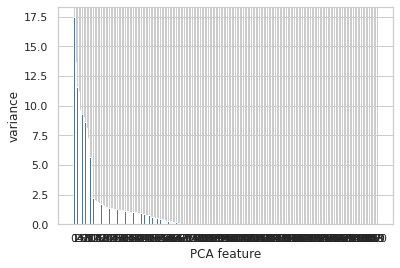

In [37]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
ss=StandardScaler()
pca=PCA()

pipeline = make_pipeline(ss, pca)
pipeline.fit(X_new)
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

In [38]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(
    X_new, y, test_size=0.3, random_state=42)

In [39]:
#rfc
from sklearn.ensemble import RandomForestRegressor
rfc = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=1, n_jobs=-1)

rfc.fit(X_train4, y_train4)
print(rfc.score(X_test4, y_test4))
count2=0
for i in rfc.feature_importances_:
    count2+=1
count2
idx_list=[]
for idx,value in enumerate(rfc.feature_importances_):
    if value>0.01:
        print(idx,value)
        idx_list.append(idx)
idx_list
features_names=pol_features.get_feature_names(X4.columns)
features_list=[]
for idx in idx_list:
    print(features_names[idx])
    features_list.append(features_names[idx])
features_list

0.8682090430619106
1 0.028170458027618184
19 0.029310408342474642
20 0.023494983921848206
24 0.020445274809909562
25 0.017920283032786036
37 0.04863120666231274
42 0.5039605291245609
54 0.10583424755775078
109 0.04592170106957147
110 0.01262975902436999
120 0.05225644941835256
124 0.014965768247635904
184 0.044825468832703545
age
obese_smoker
age bmi
age smoker_no
age smoker_yes
age obese_smoker
bmi smoker_yes
bmi obese_smoker
smoker_no age_cat_young adult
smoker_no age_cat_senior adult
smoker_yes bmi_cat_obesity
smoker_yes obese_smoker
bmi_cat_obesity obese_smoker


/home/mm/anaconda3/envs/ml/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['age',
 'obese_smoker',
 'age bmi',
 'age smoker_no',
 'age smoker_yes',
 'age obese_smoker',
 'bmi smoker_yes',
 'bmi obese_smoker',
 'smoker_no age_cat_young adult',
 'smoker_no age_cat_senior adult',
 'smoker_yes bmi_cat_obesity',
 'smoker_yes obese_smoker',
 'bmi_cat_obesity obese_smoker']

Text(0, 0.5, 'Mean decrease in impurity')

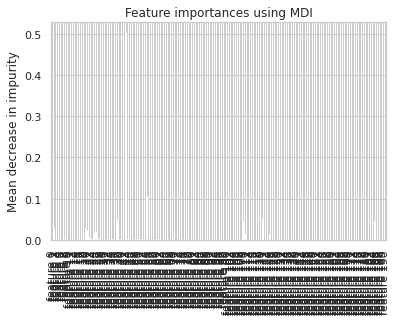

In [41]:
feature_names = [f"feature {i}" for i in range(X_new.shape[1])]
importances = rfc.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)
std = np.std([rfc.feature_importances_ for tree in rfc.estimators_], axis=0)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()